# Import

In [35]:
import torch
from torch import nn
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR, CosineAnnealingLR
from fvcore.nn import FlopCountAnalysis, flop_count_table
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [36]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
# OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"
"""Learning rate scheduler parameters"""
NUM_EPOCHS = 180

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 150

file_path = f"MyResNet34_{BATCH}_{OPTIMIZER}"

In [37]:
file_path

'MyResNet34_128_AdamW'

# Loading the dataset

## Define Dateloader

In [38]:
tmp = LoadDataset(root="../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [39]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
test.transforms = ToTensor() 128


# Define ResNet

## Model Confirm

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [41]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [42]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [43]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [44]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_path)

## (4) Define Learning Rate schedualer

In [45]:
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=0)

## (5) Define AMP scaler

In [46]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [47]:
if os.path.exists(file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

Suceessfully loaded the All setting and Log file.
MyResNet34_128_AdamW
Current epoch is 22
Current learning rate: 0.001


In [48]:
optimizer.param_groups[0]["lr"]

0.001

In [49]:
earlystopper.early_stop_counter

1

# [Training Loop]

In [50]:
if valid_data is None:
    valid_dataloader = None
if test_data is None:
    test_dataloader = None

In [51]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 23/180] :


23 Train: 100%|██████| 391/391 [00:14<00:00, 27.36it/s]

Train Loss: 0.5068 | Train Acc: 82.23%


Test  Loss: 0.4750 | Test Acc: 83.94%
updated best eval loss : 0.47504755326464204
--------------------------------------------------
[Epoch 24/180] :


24 Train: 100%|██████| 391/391 [00:16<00:00, 23.27it/s]


Train Loss: 0.4987 | Train Acc: 82.53%
Test  Loss: 0.5067 | Test Acc: 83.15%
--------------------------------------------------
[Epoch 25/180] :


25 Train: 100%|██████| 391/391 [00:17<00:00, 22.58it/s]


Train Loss: 0.4877 | Train Acc: 83.11%
Test  Loss: 0.6241 | Test Acc: 80.19%
--------------------------------------------------
[Epoch 26/180] :


26 Train: 100%|██████| 391/391 [00:17<00:00, 22.04it/s]


Train Loss: 0.4759 | Train Acc: 83.34%
Test  Loss: 0.5545 | Test Acc: 81.76%
--------------------------------------------------
[Epoch 27/180] :


27 Train: 100%|██████| 391/391 [00:17<00:00, 22.92it/s]


Train Loss: 0.4789 | Train Acc: 83.22%
Test  Loss: 0.6062 | Test Acc: 79.86%
--------------------------------------------------
[Epoch 28/180] :


28 Train: 100%|██████| 391/391 [00:17<00:00, 22.33it/s]


Train Loss: 0.4650 | Train Acc: 83.87%
Test  Loss: 0.5065 | Test Acc: 82.71%
--------------------------------------------------
[Epoch 29/180] :


29 Train: 100%|██████| 391/391 [00:17<00:00, 22.64it/s]


Train Loss: 0.4564 | Train Acc: 84.07%
Test  Loss: 0.4572 | Test Acc: 84.94%
updated best eval loss : 0.45722970781447014
--------------------------------------------------
[Epoch 30/180] :


30 Train: 100%|██████| 391/391 [00:16<00:00, 23.29it/s]


Train Loss: 0.4521 | Train Acc: 84.33%
Test  Loss: 0.5749 | Test Acc: 81.76%
--------------------------------------------------
[Epoch 31/180] :


31 Train: 100%|██████| 391/391 [00:17<00:00, 22.87it/s]


Train Loss: 0.4441 | Train Acc: 84.36%
Test  Loss: 0.4537 | Test Acc: 84.75%
updated best eval loss : 0.4536909223357333
--------------------------------------------------
[Epoch 32/180] :


32 Train: 100%|██████| 391/391 [00:17<00:00, 22.60it/s]


Train Loss: 0.4345 | Train Acc: 84.79%
Test  Loss: 0.5519 | Test Acc: 82.18%
--------------------------------------------------
[Epoch 33/180] :


33 Train: 100%|██████| 391/391 [00:18<00:00, 21.41it/s]


Train Loss: 0.4324 | Train Acc: 84.98%
Test  Loss: 0.5543 | Test Acc: 81.59%
--------------------------------------------------
[Epoch 34/180] :


34 Train: 100%|██████| 391/391 [00:18<00:00, 21.67it/s]


Train Loss: 0.4285 | Train Acc: 84.98%
Test  Loss: 0.5702 | Test Acc: 81.32%
--------------------------------------------------
[Epoch 35/180] :


35 Train: 100%|██████| 391/391 [00:17<00:00, 22.11it/s]


Train Loss: 0.4227 | Train Acc: 85.39%
Test  Loss: 0.4205 | Test Acc: 85.34%
updated best eval loss : 0.42047514285467846
--------------------------------------------------
[Epoch 36/180] :


36 Train: 100%|██████| 391/391 [00:16<00:00, 23.14it/s]


Train Loss: 0.4169 | Train Acc: 85.50%
Test  Loss: 0.4786 | Test Acc: 84.35%
--------------------------------------------------
[Epoch 37/180] :


37 Train: 100%|██████| 391/391 [00:17<00:00, 22.59it/s]


Train Loss: 0.4127 | Train Acc: 85.58%
Test  Loss: 0.5540 | Test Acc: 82.10%
--------------------------------------------------
[Epoch 38/180] :


38 Train: 100%|██████| 391/391 [00:17<00:00, 21.82it/s]


Train Loss: 0.4027 | Train Acc: 85.82%
Test  Loss: 0.5010 | Test Acc: 83.72%
--------------------------------------------------
[Epoch 39/180] :


39 Train: 100%|██████| 391/391 [00:17<00:00, 22.87it/s]


Train Loss: 0.4068 | Train Acc: 85.61%
Test  Loss: 0.4568 | Test Acc: 84.68%
--------------------------------------------------
[Epoch 40/180] :


40 Train: 100%|██████| 391/391 [00:17<00:00, 22.20it/s]


Train Loss: 0.3918 | Train Acc: 86.46%
Test  Loss: 0.5178 | Test Acc: 83.59%
--------------------------------------------------
[Epoch 41/180] :


41 Train: 100%|██████| 391/391 [00:17<00:00, 22.19it/s]


Train Loss: 0.3961 | Train Acc: 86.21%
Test  Loss: 0.5040 | Test Acc: 83.73%
--------------------------------------------------
[Epoch 42/180] :


42 Train: 100%|██████| 391/391 [00:18<00:00, 21.69it/s]


Train Loss: 0.3835 | Train Acc: 86.65%
Test  Loss: 0.5658 | Test Acc: 82.78%
--------------------------------------------------
[Epoch 43/180] :


43 Train: 100%|██████| 391/391 [00:17<00:00, 22.22it/s]


Train Loss: 0.3869 | Train Acc: 86.49%
Test  Loss: 0.5301 | Test Acc: 83.09%
--------------------------------------------------
[Epoch 44/180] :


44 Train: 100%|██████| 391/391 [00:17<00:00, 22.38it/s]


Train Loss: 0.3851 | Train Acc: 86.60%
Test  Loss: 0.5550 | Test Acc: 82.11%
--------------------------------------------------
[Epoch 45/180] :


45 Train: 100%|██████| 391/391 [00:16<00:00, 23.23it/s]


Train Loss: 0.3816 | Train Acc: 86.54%
Test  Loss: 0.5165 | Test Acc: 82.93%
--------------------------------------------------
[Epoch 46/180] :


46 Train: 100%|██████| 391/391 [00:16<00:00, 24.07it/s]


Train Loss: 0.3712 | Train Acc: 86.94%
Test  Loss: 0.4479 | Test Acc: 84.92%
--------------------------------------------------
[Epoch 47/180] :


47 Train: 100%|██████| 391/391 [00:17<00:00, 22.20it/s]


Train Loss: 0.3714 | Train Acc: 86.99%
Test  Loss: 0.4684 | Test Acc: 84.31%
--------------------------------------------------
[Epoch 48/180] :


48 Train: 100%|██████| 391/391 [00:17<00:00, 22.39it/s]


Train Loss: 0.3720 | Train Acc: 86.78%
Test  Loss: 0.4832 | Test Acc: 84.67%
--------------------------------------------------
[Epoch 49/180] :


49 Train: 100%|██████| 391/391 [00:17<00:00, 22.41it/s]


Train Loss: 0.3685 | Train Acc: 87.11%
Test  Loss: 0.4876 | Test Acc: 85.29%
--------------------------------------------------
[Epoch 50/180] :


50 Train: 100%|██████| 391/391 [00:17<00:00, 22.39it/s]


Train Loss: 0.3583 | Train Acc: 87.45%
Test  Loss: 0.4864 | Test Acc: 84.46%
--------------------------------------------------
[Epoch 51/180] :


51 Train: 100%|██████| 391/391 [00:16<00:00, 23.05it/s]


Train Loss: 0.3578 | Train Acc: 87.35%
Test  Loss: 0.4627 | Test Acc: 85.36%
--------------------------------------------------
[Epoch 52/180] :


52 Train: 100%|██████| 391/391 [00:17<00:00, 22.93it/s]


Train Loss: 0.3525 | Train Acc: 87.56%
Test  Loss: 0.4097 | Test Acc: 86.59%
updated best eval loss : 0.4097478157734569
--------------------------------------------------
[Epoch 53/180] :


53 Train: 100%|██████| 391/391 [00:17<00:00, 22.67it/s]


Train Loss: 0.3527 | Train Acc: 87.53%
Test  Loss: 0.4362 | Test Acc: 86.24%
--------------------------------------------------
[Epoch 54/180] :


54 Train: 100%|██████| 391/391 [00:17<00:00, 22.18it/s]


Train Loss: 0.3473 | Train Acc: 87.86%
Test  Loss: 0.4603 | Test Acc: 85.65%
--------------------------------------------------
[Epoch 55/180] :


55 Train: 100%|██████| 391/391 [00:17<00:00, 22.85it/s]


Train Loss: 0.3486 | Train Acc: 87.75%
Test  Loss: 0.4917 | Test Acc: 84.34%
--------------------------------------------------
[Epoch 56/180] :


56 Train: 100%|██████| 391/391 [00:18<00:00, 21.32it/s]


Train Loss: 0.3423 | Train Acc: 87.87%
Test  Loss: 0.5767 | Test Acc: 81.76%
--------------------------------------------------
[Epoch 57/180] :


57 Train: 100%|██████| 391/391 [00:17<00:00, 22.66it/s]


Train Loss: 0.3432 | Train Acc: 88.00%
Test  Loss: 0.4309 | Test Acc: 86.24%
--------------------------------------------------
[Epoch 58/180] :


58 Train: 100%|██████| 391/391 [00:17<00:00, 22.24it/s]


Train Loss: 0.3416 | Train Acc: 88.01%
Test  Loss: 0.5172 | Test Acc: 84.04%
--------------------------------------------------
[Epoch 59/180] :


59 Train: 100%|██████| 391/391 [00:17<00:00, 22.06it/s]


Train Loss: 0.3384 | Train Acc: 88.32%
Test  Loss: 0.4545 | Test Acc: 85.29%
--------------------------------------------------
[Epoch 60/180] :


60 Train: 100%|██████| 391/391 [00:17<00:00, 22.04it/s]


Train Loss: 0.3341 | Train Acc: 88.47%
Test  Loss: 0.4846 | Test Acc: 84.73%
--------------------------------------------------
[Epoch 61/180] :


61 Train: 100%|██████| 391/391 [00:17<00:00, 22.02it/s]


Train Loss: 0.3319 | Train Acc: 88.52%
Test  Loss: 0.4920 | Test Acc: 85.07%
--------------------------------------------------
[Epoch 62/180] :


62 Train: 100%|██████| 391/391 [00:17<00:00, 22.36it/s]


Train Loss: 0.3271 | Train Acc: 88.60%
Test  Loss: 0.5398 | Test Acc: 83.59%
--------------------------------------------------
[Epoch 63/180] :


63 Train: 100%|██████| 391/391 [00:17<00:00, 22.09it/s]


Train Loss: 0.3276 | Train Acc: 88.60%
Test  Loss: 0.4617 | Test Acc: 85.93%
--------------------------------------------------
[Epoch 64/180] :


64 Train: 100%|██████| 391/391 [00:16<00:00, 23.03it/s]


Train Loss: 0.3259 | Train Acc: 88.54%
Test  Loss: 0.5041 | Test Acc: 84.45%
--------------------------------------------------
[Epoch 65/180] :


65 Train: 100%|██████| 391/391 [00:17<00:00, 22.36it/s]


Train Loss: 0.3228 | Train Acc: 88.75%
Test  Loss: 0.4451 | Test Acc: 86.38%
--------------------------------------------------
[Epoch 66/180] :


66 Train: 100%|██████| 391/391 [00:17<00:00, 21.91it/s]


Train Loss: 0.3157 | Train Acc: 88.95%
Test  Loss: 0.5055 | Test Acc: 84.50%
--------------------------------------------------
[Epoch 67/180] :


67 Train: 100%|██████| 391/391 [00:17<00:00, 21.80it/s]


Train Loss: 0.3218 | Train Acc: 88.79%
Test  Loss: 0.4217 | Test Acc: 86.60%
--------------------------------------------------
[Epoch 68/180] :


68 Train: 100%|██████| 391/391 [00:17<00:00, 22.96it/s]


Train Loss: 0.3163 | Train Acc: 89.09%
Test  Loss: 0.4386 | Test Acc: 86.46%
--------------------------------------------------
[Epoch 69/180] :


69 Train: 100%|██████| 391/391 [00:17<00:00, 22.04it/s]


Train Loss: 0.3162 | Train Acc: 88.94%
Test  Loss: 0.4634 | Test Acc: 85.69%
--------------------------------------------------
[Epoch 70/180] :


70 Train: 100%|██████| 391/391 [00:17<00:00, 21.78it/s]


Train Loss: 0.3106 | Train Acc: 89.00%
Test  Loss: 0.4767 | Test Acc: 84.68%
--------------------------------------------------
[Epoch 71/180] :


71 Train: 100%|██████| 391/391 [00:17<00:00, 22.14it/s]


Train Loss: 0.3122 | Train Acc: 89.09%
Test  Loss: 0.4584 | Test Acc: 85.48%
--------------------------------------------------
[Epoch 72/180] :


72 Train: 100%|██████| 391/391 [00:17<00:00, 22.04it/s]


Train Loss: 0.3122 | Train Acc: 89.06%
Test  Loss: 0.5112 | Test Acc: 84.10%
--------------------------------------------------
[Epoch 73/180] :


73 Train: 100%|██████| 391/391 [00:18<00:00, 21.70it/s]


Train Loss: 0.3037 | Train Acc: 89.31%
Test  Loss: 0.4801 | Test Acc: 85.58%
--------------------------------------------------
[Epoch 74/180] :


74 Train: 100%|██████| 391/391 [00:17<00:00, 21.92it/s]


Train Loss: 0.3016 | Train Acc: 89.31%
Test  Loss: 0.4626 | Test Acc: 85.68%
--------------------------------------------------
[Epoch 75/180] :


75 Train: 100%|██████| 391/391 [00:17<00:00, 22.90it/s]


Train Loss: 0.3015 | Train Acc: 89.35%
Test  Loss: 0.4535 | Test Acc: 86.27%
--------------------------------------------------
[Epoch 76/180] :


76 Train: 100%|██████| 391/391 [00:17<00:00, 21.77it/s]


Train Loss: 0.3009 | Train Acc: 89.55%
Test  Loss: 0.4354 | Test Acc: 86.57%
--------------------------------------------------
[Epoch 77/180] :


77 Train: 100%|██████| 391/391 [00:17<00:00, 22.40it/s]


Train Loss: 0.2948 | Train Acc: 89.64%
Test  Loss: 0.4522 | Test Acc: 86.32%
--------------------------------------------------
[Epoch 78/180] :


78 Train: 100%|██████| 391/391 [00:17<00:00, 22.85it/s]


Train Loss: 0.2968 | Train Acc: 89.65%
Test  Loss: 0.4437 | Test Acc: 86.46%
--------------------------------------------------
[Epoch 79/180] :


79 Train: 100%|██████| 391/391 [00:17<00:00, 22.14it/s]


Train Loss: 0.2940 | Train Acc: 89.70%
Test  Loss: 0.3936 | Test Acc: 87.96%
updated best eval loss : 0.3935560717990127
--------------------------------------------------
[Epoch 80/180] :


80 Train: 100%|██████| 391/391 [00:17<00:00, 22.01it/s]


Train Loss: 0.2963 | Train Acc: 89.53%
Test  Loss: 0.5296 | Test Acc: 84.47%
--------------------------------------------------
[Epoch 81/180] :


81 Train: 100%|██████| 391/391 [00:17<00:00, 21.98it/s]


Train Loss: 0.2928 | Train Acc: 89.84%
Test  Loss: 0.3961 | Test Acc: 87.35%
--------------------------------------------------
[Epoch 82/180] :


82 Train: 100%|██████| 391/391 [00:18<00:00, 21.47it/s]


Train Loss: 0.2919 | Train Acc: 89.83%
Test  Loss: 0.4163 | Test Acc: 87.16%
--------------------------------------------------
[Epoch 83/180] :


83 Train: 100%|██████| 391/391 [00:17<00:00, 22.52it/s]


Train Loss: 0.2870 | Train Acc: 89.88%
Test  Loss: 0.5059 | Test Acc: 84.93%
--------------------------------------------------
[Epoch 84/180] :


84 Train: 100%|██████| 391/391 [00:16<00:00, 23.38it/s]


Train Loss: 0.2859 | Train Acc: 89.86%
Test  Loss: 0.4022 | Test Acc: 87.00%
--------------------------------------------------
[Epoch 85/180] :


85 Train: 100%|██████| 391/391 [00:17<00:00, 22.55it/s]


Train Loss: 0.2837 | Train Acc: 90.05%
Test  Loss: 0.4110 | Test Acc: 87.03%
--------------------------------------------------
[Epoch 86/180] :


86 Train: 100%|██████| 391/391 [00:18<00:00, 21.39it/s]


Train Loss: 0.2819 | Train Acc: 90.07%
Test  Loss: 0.5446 | Test Acc: 84.85%
--------------------------------------------------
[Epoch 87/180] :


87 Train: 100%|██████| 391/391 [00:17<00:00, 22.53it/s]


Train Loss: 0.2810 | Train Acc: 90.18%
Test  Loss: 0.4341 | Test Acc: 87.07%
--------------------------------------------------
[Epoch 88/180] :


88 Train: 100%|██████| 391/391 [00:17<00:00, 22.51it/s]


Train Loss: 0.2773 | Train Acc: 90.42%
Test  Loss: 0.4181 | Test Acc: 87.48%
--------------------------------------------------
[Epoch 89/180] :


89 Train: 100%|██████| 391/391 [00:17<00:00, 22.84it/s]


Train Loss: 0.2835 | Train Acc: 90.03%
Test  Loss: 0.4339 | Test Acc: 86.76%
--------------------------------------------------
[Epoch 90/180] :


90 Train: 100%|██████| 391/391 [00:17<00:00, 22.64it/s]


Train Loss: 0.2859 | Train Acc: 89.84%
Test  Loss: 0.3863 | Test Acc: 87.92%
updated best eval loss : 0.3863440964229499
--------------------------------------------------
[Epoch 91/180] :


91 Train: 100%|██████| 391/391 [00:17<00:00, 22.47it/s]


Train Loss: 0.2721 | Train Acc: 90.48%
Test  Loss: 0.4253 | Test Acc: 87.07%
--------------------------------------------------
[Epoch 92/180] :


92 Train: 100%|██████| 391/391 [00:17<00:00, 21.90it/s]


Train Loss: 0.2752 | Train Acc: 90.34%
Test  Loss: 0.4151 | Test Acc: 87.33%
--------------------------------------------------
[Epoch 93/180] :


93 Train: 100%|██████| 391/391 [00:17<00:00, 22.56it/s]


Train Loss: 0.2699 | Train Acc: 90.46%
Test  Loss: 0.4252 | Test Acc: 87.36%
--------------------------------------------------
[Epoch 94/180] :


94 Train: 100%|██████| 391/391 [00:17<00:00, 22.68it/s]


Train Loss: 0.2738 | Train Acc: 90.48%
Test  Loss: 0.3877 | Test Acc: 88.20%
--------------------------------------------------
[Epoch 95/180] :


95 Train: 100%|██████| 391/391 [00:17<00:00, 22.39it/s]


Train Loss: 0.2678 | Train Acc: 90.60%
Test  Loss: 0.4696 | Test Acc: 85.86%
--------------------------------------------------
[Epoch 96/180] :


96 Train: 100%|██████| 391/391 [00:17<00:00, 22.99it/s]


Train Loss: 0.2665 | Train Acc: 90.61%
Test  Loss: 0.4355 | Test Acc: 86.72%
--------------------------------------------------
[Epoch 97/180] :


97 Train: 100%|██████| 391/391 [00:17<00:00, 22.57it/s]


Train Loss: 0.2692 | Train Acc: 90.46%
Test  Loss: 0.3818 | Test Acc: 87.77%
updated best eval loss : 0.38175699171386185
--------------------------------------------------
[Epoch 98/180] :


98 Train: 100%|██████| 391/391 [00:17<00:00, 21.74it/s]


Train Loss: 0.2663 | Train Acc: 90.68%
Test  Loss: 0.4207 | Test Acc: 86.91%
--------------------------------------------------
[Epoch 99/180] :


99 Train: 100%|██████| 391/391 [00:17<00:00, 22.93it/s]


Train Loss: 0.2638 | Train Acc: 90.78%
Test  Loss: 0.4239 | Test Acc: 87.51%
--------------------------------------------------
[Epoch 100/180] :


100 Train: 100%|█████| 391/391 [00:17<00:00, 21.90it/s]


Train Loss: 0.2649 | Train Acc: 90.75%
Test  Loss: 0.3954 | Test Acc: 87.70%
--------------------------------------------------
[Epoch 101/180] :


101 Train: 100%|█████| 391/391 [00:17<00:00, 22.14it/s]


Train Loss: 0.2644 | Train Acc: 90.72%
Test  Loss: 0.4821 | Test Acc: 85.84%
--------------------------------------------------
[Epoch 102/180] :


102 Train: 100%|█████| 391/391 [00:17<00:00, 22.20it/s]


Train Loss: 0.2673 | Train Acc: 90.65%
Test  Loss: 0.4507 | Test Acc: 86.37%
--------------------------------------------------
[Epoch 103/180] :


103 Train: 100%|█████| 391/391 [00:17<00:00, 22.41it/s]


Train Loss: 0.2597 | Train Acc: 90.79%
Test  Loss: 0.4096 | Test Acc: 87.54%
--------------------------------------------------
[Epoch 104/180] :


104 Train: 100%|█████| 391/391 [00:17<00:00, 22.57it/s]


Train Loss: 0.2645 | Train Acc: 90.75%
Test  Loss: 0.4122 | Test Acc: 87.32%
--------------------------------------------------
[Epoch 105/180] :


105 Train: 100%|█████| 391/391 [00:17<00:00, 22.83it/s]


Train Loss: 0.2542 | Train Acc: 91.04%
Test  Loss: 0.4076 | Test Acc: 87.61%
--------------------------------------------------
[Epoch 106/180] :


106 Train: 100%|█████| 391/391 [00:18<00:00, 21.33it/s]


Train Loss: 0.2551 | Train Acc: 91.00%
Test  Loss: 0.3799 | Test Acc: 88.36%
updated best eval loss : 0.379862513911875
--------------------------------------------------
[Epoch 107/180] :


107 Train: 100%|█████| 391/391 [00:18<00:00, 21.43it/s]


Train Loss: 0.2548 | Train Acc: 91.13%
Test  Loss: 0.4179 | Test Acc: 87.15%
--------------------------------------------------
[Epoch 108/180] :


108 Train: 100%|█████| 391/391 [00:17<00:00, 22.64it/s]


Train Loss: 0.2514 | Train Acc: 91.11%
Test  Loss: 0.4012 | Test Acc: 87.97%
--------------------------------------------------
[Epoch 109/180] :


109 Train: 100%|█████| 391/391 [00:18<00:00, 21.50it/s]


Train Loss: 0.2590 | Train Acc: 90.92%
Test  Loss: 0.4310 | Test Acc: 87.48%
--------------------------------------------------
[Epoch 110/180] :


110 Train: 100%|█████| 391/391 [00:17<00:00, 22.44it/s]


Train Loss: 0.2505 | Train Acc: 91.32%
Test  Loss: 0.4058 | Test Acc: 87.68%
--------------------------------------------------
[Epoch 111/180] :


111 Train: 100%|█████| 391/391 [00:17<00:00, 22.29it/s]


Train Loss: 0.2558 | Train Acc: 90.98%
Test  Loss: 0.4285 | Test Acc: 87.30%
--------------------------------------------------
[Epoch 112/180] :


112 Train: 100%|█████| 391/391 [00:17<00:00, 21.98it/s]


Train Loss: 0.2500 | Train Acc: 91.21%
Test  Loss: 0.4262 | Test Acc: 87.63%
--------------------------------------------------
[Epoch 113/180] :


113 Train: 100%|█████| 391/391 [00:17<00:00, 22.00it/s]


Train Loss: 0.2450 | Train Acc: 91.39%
Test  Loss: 0.4315 | Test Acc: 87.35%
--------------------------------------------------
[Epoch 114/180] :


114 Train: 100%|█████| 391/391 [00:17<00:00, 22.45it/s]


Train Loss: 0.2553 | Train Acc: 91.07%
Test  Loss: 0.4455 | Test Acc: 86.70%
--------------------------------------------------
[Epoch 115/180] :


115 Train: 100%|█████| 391/391 [00:17<00:00, 22.52it/s]


Train Loss: 0.2486 | Train Acc: 91.30%
Test  Loss: 0.4707 | Test Acc: 86.29%
--------------------------------------------------
[Epoch 116/180] :


116 Train: 100%|█████| 391/391 [00:17<00:00, 21.89it/s]


Train Loss: 0.2507 | Train Acc: 91.24%
Test  Loss: 0.3979 | Test Acc: 88.06%
--------------------------------------------------
[Epoch 117/180] :


117 Train: 100%|█████| 391/391 [00:17<00:00, 22.62it/s]


Train Loss: 0.2502 | Train Acc: 91.18%
Test  Loss: 0.3640 | Test Acc: 89.21%
updated best eval loss : 0.36401789899491055
--------------------------------------------------
[Epoch 118/180] :


118 Train: 100%|█████| 391/391 [00:18<00:00, 20.97it/s]


Train Loss: 0.2487 | Train Acc: 91.29%
Test  Loss: 0.4225 | Test Acc: 87.63%
--------------------------------------------------
[Epoch 119/180] :


119 Train: 100%|█████| 391/391 [00:17<00:00, 22.90it/s]


Train Loss: 0.2447 | Train Acc: 91.37%
Test  Loss: 0.4412 | Test Acc: 87.06%
--------------------------------------------------
[Epoch 120/180] :


120 Train: 100%|█████| 391/391 [00:17<00:00, 21.86it/s]


Train Loss: 0.2422 | Train Acc: 91.44%
Test  Loss: 0.4126 | Test Acc: 87.74%
--------------------------------------------------
[Epoch 121/180] :


121 Train: 100%|█████| 391/391 [00:17<00:00, 21.75it/s]


Train Loss: 0.2398 | Train Acc: 91.54%
Test  Loss: 0.4656 | Test Acc: 86.21%
--------------------------------------------------
[Epoch 122/180] :


122 Train: 100%|█████| 391/391 [00:17<00:00, 22.37it/s]


Train Loss: 0.2391 | Train Acc: 91.58%
Test  Loss: 0.4551 | Test Acc: 86.35%
--------------------------------------------------
[Epoch 123/180] :


123 Train: 100%|█████| 391/391 [00:17<00:00, 22.50it/s]


Train Loss: 0.2422 | Train Acc: 91.59%
Test  Loss: 0.4548 | Test Acc: 86.30%
--------------------------------------------------
[Epoch 124/180] :


124 Train: 100%|█████| 391/391 [00:17<00:00, 22.23it/s]


Train Loss: 0.2396 | Train Acc: 91.44%
Test  Loss: 0.4151 | Test Acc: 87.60%
--------------------------------------------------
[Epoch 125/180] :


125 Train: 100%|█████| 391/391 [00:17<00:00, 21.93it/s]


Train Loss: 0.2380 | Train Acc: 91.59%
Test  Loss: 0.4505 | Test Acc: 86.10%
--------------------------------------------------
[Epoch 126/180] :


126 Train: 100%|█████| 391/391 [00:16<00:00, 23.40it/s]


Train Loss: 0.2386 | Train Acc: 91.73%
Test  Loss: 0.4437 | Test Acc: 87.31%
--------------------------------------------------
[Epoch 127/180] :


127 Train: 100%|█████| 391/391 [00:17<00:00, 21.99it/s]


Train Loss: 0.2400 | Train Acc: 91.65%
Test  Loss: 0.4075 | Test Acc: 87.69%
--------------------------------------------------
[Epoch 128/180] :


128 Train: 100%|█████| 391/391 [00:17<00:00, 21.87it/s]


Train Loss: 0.2367 | Train Acc: 91.72%
Test  Loss: 0.4171 | Test Acc: 87.68%
--------------------------------------------------
[Epoch 129/180] :


129 Train: 100%|█████| 391/391 [00:17<00:00, 22.23it/s]


Train Loss: 0.2395 | Train Acc: 91.62%
Test  Loss: 0.4574 | Test Acc: 86.89%
--------------------------------------------------
[Epoch 130/180] :


130 Train: 100%|█████| 391/391 [00:17<00:00, 22.43it/s]


Train Loss: 0.2359 | Train Acc: 91.82%
Test  Loss: 0.4539 | Test Acc: 86.46%
--------------------------------------------------
[Epoch 131/180] :


131 Train: 100%|█████| 391/391 [00:17<00:00, 22.99it/s]


Train Loss: 0.2390 | Train Acc: 91.69%
Test  Loss: 0.4510 | Test Acc: 87.11%
--------------------------------------------------
[Epoch 132/180] :


132 Train: 100%|█████| 391/391 [00:14<00:00, 26.23it/s]


Train Loss: 0.2396 | Train Acc: 91.66%
Test  Loss: 0.4255 | Test Acc: 87.29%
--------------------------------------------------
[Epoch 133/180] :


133 Train: 100%|█████| 391/391 [00:13<00:00, 29.07it/s]


Train Loss: 0.2356 | Train Acc: 91.70%
Test  Loss: 0.4321 | Test Acc: 86.84%
--------------------------------------------------
[Epoch 134/180] :


134 Train: 100%|█████| 391/391 [00:13<00:00, 28.80it/s]


Train Loss: 0.2284 | Train Acc: 92.01%
Test  Loss: 0.4051 | Test Acc: 88.23%
--------------------------------------------------
[Epoch 135/180] :


135 Train: 100%|█████| 391/391 [00:13<00:00, 28.21it/s]


Train Loss: 0.2302 | Train Acc: 91.93%
Test  Loss: 0.4181 | Test Acc: 87.48%
--------------------------------------------------
[Epoch 136/180] :


136 Train: 100%|█████| 391/391 [00:13<00:00, 28.92it/s]


Train Loss: 0.2298 | Train Acc: 92.06%
Test  Loss: 0.4174 | Test Acc: 87.68%
--------------------------------------------------
[Epoch 137/180] :


137 Train: 100%|█████| 391/391 [00:13<00:00, 28.29it/s]


Train Loss: 0.2322 | Train Acc: 91.80%
Test  Loss: 0.4166 | Test Acc: 87.59%
--------------------------------------------------
[Epoch 138/180] :


138 Train: 100%|█████| 391/391 [00:17<00:00, 21.97it/s]


Train Loss: 0.2305 | Train Acc: 92.02%
Test  Loss: 0.4053 | Test Acc: 87.89%
--------------------------------------------------
[Epoch 139/180] :


139 Train: 100%|█████| 391/391 [00:17<00:00, 21.99it/s]


Train Loss: 0.2275 | Train Acc: 92.06%
Test  Loss: 0.4285 | Test Acc: 87.77%
--------------------------------------------------
[Epoch 140/180] :


140 Train: 100%|█████| 391/391 [00:17<00:00, 21.86it/s]


Train Loss: 0.2244 | Train Acc: 92.07%
Test  Loss: 0.4295 | Test Acc: 87.77%
--------------------------------------------------
[Epoch 141/180] :


141 Train: 100%|█████| 391/391 [00:16<00:00, 23.23it/s]


Train Loss: 0.2292 | Train Acc: 92.05%
Test  Loss: 0.4596 | Test Acc: 87.32%
--------------------------------------------------
[Epoch 142/180] :


142 Train: 100%|█████| 391/391 [00:17<00:00, 22.63it/s]


Train Loss: 0.2224 | Train Acc: 92.25%
Test  Loss: 0.4052 | Test Acc: 88.56%
--------------------------------------------------
[Epoch 143/180] :


143 Train: 100%|█████| 391/391 [00:17<00:00, 22.60it/s]


Train Loss: 0.2260 | Train Acc: 92.08%
Test  Loss: 0.4697 | Test Acc: 87.28%
--------------------------------------------------
[Epoch 144/180] :


144 Train: 100%|█████| 391/391 [00:18<00:00, 21.37it/s]


Train Loss: 0.2190 | Train Acc: 92.45%
Test  Loss: 0.4139 | Test Acc: 88.14%
--------------------------------------------------
[Epoch 145/180] :


145 Train: 100%|█████| 391/391 [00:17<00:00, 22.13it/s]


Train Loss: 0.2262 | Train Acc: 91.96%
Test  Loss: 0.4517 | Test Acc: 87.34%
--------------------------------------------------
[Epoch 146/180] :


146 Train: 100%|█████| 391/391 [00:17<00:00, 21.95it/s]


Train Loss: 0.2289 | Train Acc: 92.03%
Test  Loss: 0.4019 | Test Acc: 88.09%
--------------------------------------------------
[Epoch 147/180] :


147 Train: 100%|█████| 391/391 [00:17<00:00, 22.41it/s]


Train Loss: 0.2206 | Train Acc: 92.38%
Test  Loss: 0.3745 | Test Acc: 89.28%
--------------------------------------------------
[Epoch 148/180] :


148 Train: 100%|█████| 391/391 [00:17<00:00, 22.95it/s]


Train Loss: 0.2196 | Train Acc: 92.37%
Test  Loss: 0.4410 | Test Acc: 87.19%
--------------------------------------------------
[Epoch 149/180] :


149 Train: 100%|█████| 391/391 [00:17<00:00, 22.26it/s]


Train Loss: 0.2231 | Train Acc: 92.20%
Test  Loss: 0.4079 | Test Acc: 88.14%
--------------------------------------------------
[Epoch 150/180] :


150 Train: 100%|█████| 391/391 [00:16<00:00, 23.56it/s]


Train Loss: 0.2210 | Train Acc: 92.29%
Test  Loss: 0.4185 | Test Acc: 87.53%
--------------------------------------------------
[Epoch 151/180] :


151 Train: 100%|█████| 391/391 [00:18<00:00, 21.67it/s]


Train Loss: 0.2189 | Train Acc: 92.33%
Test  Loss: 0.4045 | Test Acc: 88.44%
--------------------------------------------------
[Epoch 152/180] :


152 Train: 100%|█████| 391/391 [00:18<00:00, 21.28it/s]


Train Loss: 0.2199 | Train Acc: 92.33%
Test  Loss: 0.4022 | Test Acc: 88.32%
--------------------------------------------------
[Epoch 153/180] :


153 Train: 100%|█████| 391/391 [00:17<00:00, 22.97it/s]


Train Loss: 0.2244 | Train Acc: 92.26%
Test  Loss: 0.4355 | Test Acc: 87.51%
--------------------------------------------------
[Epoch 154/180] :


154 Train: 100%|█████| 391/391 [00:17<00:00, 22.92it/s]


Train Loss: 0.2174 | Train Acc: 92.33%
Test  Loss: 0.4072 | Test Acc: 88.67%
--------------------------------------------------
[Epoch 155/180] :


155 Train: 100%|█████| 391/391 [00:17<00:00, 21.84it/s]


Train Loss: 0.2183 | Train Acc: 92.38%
Test  Loss: 0.4152 | Test Acc: 88.03%
--------------------------------------------------
[Epoch 156/180] :


156 Train: 100%|█████| 391/391 [00:17<00:00, 22.65it/s]


Train Loss: 0.2162 | Train Acc: 92.60%
Test  Loss: 0.4264 | Test Acc: 88.03%
--------------------------------------------------
[Epoch 157/180] :


157 Train: 100%|█████| 391/391 [00:17<00:00, 22.06it/s]


Train Loss: 0.2139 | Train Acc: 92.50%
Test  Loss: 0.4237 | Test Acc: 87.81%
--------------------------------------------------
[Epoch 158/180] :


158 Train: 100%|█████| 391/391 [00:17<00:00, 22.73it/s]


Train Loss: 0.2194 | Train Acc: 92.35%
Test  Loss: 0.4146 | Test Acc: 88.24%
--------------------------------------------------
[Epoch 159/180] :


159 Train: 100%|█████| 391/391 [00:16<00:00, 23.00it/s]


Train Loss: 0.2127 | Train Acc: 92.72%
Test  Loss: 0.4112 | Test Acc: 88.13%
--------------------------------------------------
[Epoch 160/180] :


160 Train: 100%|█████| 391/391 [00:17<00:00, 22.11it/s]


Train Loss: 0.2193 | Train Acc: 92.29%
Test  Loss: 0.3942 | Test Acc: 88.66%
--------------------------------------------------
[Epoch 161/180] :


161 Train: 100%|█████| 391/391 [00:16<00:00, 23.50it/s]


Train Loss: 0.2173 | Train Acc: 92.30%
Test  Loss: 0.4373 | Test Acc: 87.48%
--------------------------------------------------
[Epoch 162/180] :


162 Train: 100%|█████| 391/391 [00:17<00:00, 21.85it/s]


Train Loss: 0.2128 | Train Acc: 92.47%
Test  Loss: 0.4028 | Test Acc: 88.41%
--------------------------------------------------
[Epoch 163/180] :


163 Train: 100%|█████| 391/391 [00:17<00:00, 22.16it/s]


Train Loss: 0.2149 | Train Acc: 92.39%
Test  Loss: 0.4651 | Test Acc: 86.63%
--------------------------------------------------
[Epoch 164/180] :


164 Train: 100%|█████| 391/391 [00:17<00:00, 22.76it/s]


Train Loss: 0.2104 | Train Acc: 92.68%
Test  Loss: 0.4433 | Test Acc: 87.84%
--------------------------------------------------
[Epoch 165/180] :


165 Train: 100%|█████| 391/391 [00:17<00:00, 22.87it/s]


Train Loss: 0.2076 | Train Acc: 92.76%
Test  Loss: 0.3702 | Test Acc: 89.09%
--------------------------------------------------
[Epoch 166/180] :


166 Train: 100%|█████| 391/391 [00:18<00:00, 21.67it/s]


Train Loss: 0.2120 | Train Acc: 92.56%
Test  Loss: 0.4006 | Test Acc: 88.02%
--------------------------------------------------
[Epoch 167/180] :


167 Train: 100%|█████| 391/391 [00:18<00:00, 20.85it/s]


Train Loss: 0.2100 | Train Acc: 92.70%
Test  Loss: 0.4241 | Test Acc: 88.16%
--------------------------------------------------
[Epoch 168/180] :


168 Train: 100%|█████| 391/391 [00:18<00:00, 21.61it/s]


Train Loss: 0.2036 | Train Acc: 92.84%
Test  Loss: 0.4427 | Test Acc: 87.51%
--------------------------------------------------
[Epoch 169/180] :


169 Train: 100%|█████| 391/391 [00:17<00:00, 22.09it/s]


Train Loss: 0.2117 | Train Acc: 92.68%
Test  Loss: 0.4544 | Test Acc: 87.72%
--------------------------------------------------
[Epoch 170/180] :


170 Train: 100%|█████| 391/391 [00:17<00:00, 22.71it/s]


Train Loss: 0.2086 | Train Acc: 92.71%
Test  Loss: 0.4478 | Test Acc: 87.49%
--------------------------------------------------
[Epoch 171/180] :


171 Train: 100%|█████| 391/391 [00:18<00:00, 21.26it/s]


Train Loss: 0.2123 | Train Acc: 92.62%
Test  Loss: 0.4421 | Test Acc: 87.85%
--------------------------------------------------
[Epoch 172/180] :


172 Train: 100%|█████| 391/391 [00:17<00:00, 21.79it/s]


Train Loss: 0.2106 | Train Acc: 92.58%
Test  Loss: 0.4125 | Test Acc: 88.74%
--------------------------------------------------
[Epoch 173/180] :


173 Train: 100%|█████| 391/391 [00:17<00:00, 21.84it/s]


Train Loss: 0.2021 | Train Acc: 92.93%
Test  Loss: 0.4651 | Test Acc: 86.86%
--------------------------------------------------
[Epoch 174/180] :


174 Train: 100%|█████| 391/391 [00:17<00:00, 22.53it/s]


Train Loss: 0.2058 | Train Acc: 92.79%
Test  Loss: 0.4333 | Test Acc: 87.70%
--------------------------------------------------
[Epoch 175/180] :


175 Train: 100%|█████| 391/391 [00:17<00:00, 22.71it/s]


Train Loss: 0.2080 | Train Acc: 92.80%
Test  Loss: 0.4184 | Test Acc: 88.64%
--------------------------------------------------
[Epoch 176/180] :


176 Train: 100%|█████| 391/391 [00:17<00:00, 21.83it/s]


Train Loss: 0.2023 | Train Acc: 92.94%
Test  Loss: 0.4122 | Test Acc: 88.57%
--------------------------------------------------
[Epoch 177/180] :


177 Train: 100%|█████| 391/391 [00:16<00:00, 23.05it/s]


Train Loss: 0.1982 | Train Acc: 93.05%
Test  Loss: 0.3883 | Test Acc: 89.38%
--------------------------------------------------
[Epoch 178/180] :


178 Train: 100%|█████| 391/391 [00:18<00:00, 21.63it/s]


Train Loss: 0.2030 | Train Acc: 92.92%
Test  Loss: 0.3986 | Test Acc: 88.88%
--------------------------------------------------
[Epoch 179/180] :


179 Train: 100%|█████| 391/391 [00:17<00:00, 22.66it/s]


Train Loss: 0.2079 | Train Acc: 92.71%
Test  Loss: 0.4751 | Test Acc: 87.17%
--------------------------------------------------
[Epoch 180/180] :


180 Train: 100%|█████| 391/391 [00:17<00:00, 22.83it/s]


Train Loss: 0.2037 | Train Acc: 92.85%
Test  Loss: 0.4569 | Test Acc: 87.86%
--------------------------------------------------
[Epoch 181/180] :


181 Train: 100%|█████| 391/391 [00:17<00:00, 22.63it/s]


Train Loss: 0.2037 | Train Acc: 92.86%
Test  Loss: 0.4115 | Test Acc: 88.72%
--------------------------------------------------
[Epoch 182/180] :


182 Train: 100%|█████| 391/391 [00:17<00:00, 21.82it/s]


Train Loss: 0.2039 | Train Acc: 92.80%
Test  Loss: 0.3987 | Test Acc: 88.87%
--------------------------------------------------
[Epoch 183/180] :


183 Train: 100%|█████| 391/391 [00:17<00:00, 21.77it/s]


Train Loss: 0.1993 | Train Acc: 93.10%
Test  Loss: 0.3981 | Test Acc: 89.28%
--------------------------------------------------
[Epoch 184/180] :


184 Train: 100%|█████| 391/391 [00:17<00:00, 22.43it/s]


Train Loss: 0.2037 | Train Acc: 92.91%
Test  Loss: 0.3754 | Test Acc: 89.32%
--------------------------------------------------
[Epoch 185/180] :


185 Train: 100%|█████| 391/391 [00:17<00:00, 22.53it/s]


Train Loss: 0.2026 | Train Acc: 92.95%
Test  Loss: 0.3858 | Test Acc: 88.91%
--------------------------------------------------
[Epoch 186/180] :


186 Train: 100%|█████| 391/391 [00:12<00:00, 31.23it/s]


Train Loss: 0.2035 | Train Acc: 92.95%
Test  Loss: 0.4011 | Test Acc: 88.98%
--------------------------------------------------
[Epoch 187/180] :


187 Train: 100%|█████| 391/391 [00:12<00:00, 30.71it/s]


Train Loss: 0.2026 | Train Acc: 92.94%
Test  Loss: 0.4103 | Test Acc: 88.38%
--------------------------------------------------
[Epoch 188/180] :


188 Train: 100%|█████| 391/391 [00:13<00:00, 29.80it/s]


Train Loss: 0.1938 | Train Acc: 93.28%
Test  Loss: 0.4486 | Test Acc: 87.70%
--------------------------------------------------
[Epoch 189/180] :


189 Train: 100%|█████| 391/391 [00:13<00:00, 29.58it/s]


Train Loss: 0.1964 | Train Acc: 93.18%
Test  Loss: 0.3887 | Test Acc: 89.07%
--------------------------------------------------
[Epoch 190/180] :


190 Train: 100%|█████| 391/391 [00:12<00:00, 30.62it/s]


Train Loss: 0.1979 | Train Acc: 93.01%
Test  Loss: 0.4417 | Test Acc: 88.04%
--------------------------------------------------
[Epoch 191/180] :


191 Train: 100%|█████| 391/391 [00:13<00:00, 30.02it/s]


Train Loss: 0.1999 | Train Acc: 92.98%
Test  Loss: 0.3805 | Test Acc: 89.12%
--------------------------------------------------
[Epoch 192/180] :


192 Train: 100%|█████| 391/391 [00:13<00:00, 29.67it/s]


Train Loss: 0.2042 | Train Acc: 92.96%
Test  Loss: 0.4189 | Test Acc: 89.07%
--------------------------------------------------
[Epoch 193/180] :


193 Train: 100%|█████| 391/391 [00:12<00:00, 30.60it/s]


Train Loss: 0.1974 | Train Acc: 93.10%
Test  Loss: 0.4168 | Test Acc: 88.75%
--------------------------------------------------
[Epoch 194/180] :


194 Train: 100%|█████| 391/391 [00:12<00:00, 32.19it/s]


Train Loss: 0.1981 | Train Acc: 93.05%
Test  Loss: 0.3993 | Test Acc: 88.77%
--------------------------------------------------
[Epoch 195/180] :


195 Train: 100%|█████| 391/391 [00:12<00:00, 30.77it/s]


Train Loss: 0.2010 | Train Acc: 92.92%
Test  Loss: 0.4791 | Test Acc: 87.55%
--------------------------------------------------
[Epoch 196/180] :


196 Train: 100%|█████| 391/391 [00:12<00:00, 31.71it/s]


Train Loss: 0.1979 | Train Acc: 93.16%
Test  Loss: 0.4332 | Test Acc: 88.10%
--------------------------------------------------
[Epoch 197/180] :


197 Train: 100%|█████| 391/391 [00:10<00:00, 37.63it/s]


Train Loss: 0.1987 | Train Acc: 93.25%
Test  Loss: 0.4778 | Test Acc: 87.29%
--------------------------------------------------
[Epoch 198/180] :


198 Train: 100%|█████| 391/391 [00:09<00:00, 41.66it/s]


Train Loss: 0.1965 | Train Acc: 93.12%
Test  Loss: 0.3846 | Test Acc: 89.31%
--------------------------------------------------
[Epoch 199/180] :


199 Train: 100%|█████| 391/391 [00:09<00:00, 41.78it/s]


Train Loss: 0.1966 | Train Acc: 93.22%
Test  Loss: 0.4607 | Test Acc: 87.68%
--------------------------------------------------
[Epoch 200/180] :


200 Train: 100%|█████| 391/391 [00:09<00:00, 41.59it/s]


Train Loss: 0.1954 | Train Acc: 93.15%
Test  Loss: 0.4173 | Test Acc: 88.26%
--------------------------------------------------
[Epoch 201/180] :


201 Train: 100%|█████| 391/391 [00:09<00:00, 41.94it/s]


Train Loss: 0.1931 | Train Acc: 93.33%
Test  Loss: 0.4377 | Test Acc: 87.63%
--------------------------------------------------
[Epoch 202/180] :


202 Train: 100%|█████| 391/391 [00:09<00:00, 43.43it/s]


Train Loss: 0.1938 | Train Acc: 93.32%
Test  Loss: 0.4188 | Test Acc: 88.68%
--------------------------------------------------


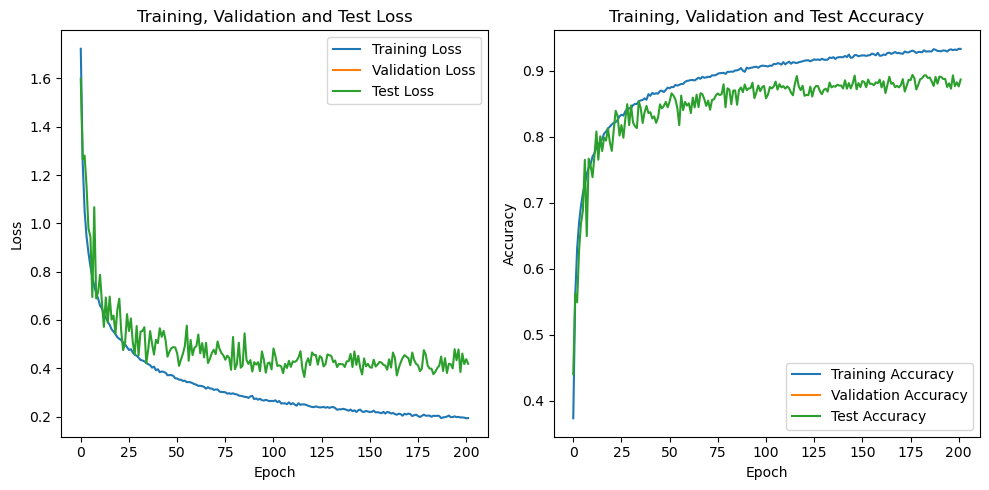

In [52]:
view = LogViewer(logs)
view.draw()

In [53]:
view.print_all()

1 epoch: train_loss=1.7226, train_acc=0.3736, test_loss=1.5981, test_acc=0.4404, lr=0.0010
2 epoch: train_loss=1.2522, train_acc=0.5575, test_loss=1.2646, test_acc=0.5625, lr=0.0010
3 epoch: train_loss=1.0498, train_acc=0.6304, test_loss=1.2804, test_acc=0.5493, lr=0.0010
4 epoch: train_loss=0.9448, train_acc=0.6695, test_loss=1.1513, test_acc=0.6279, lr=0.0010
5 epoch: train_loss=0.8777, train_acc=0.6953, test_loss=0.9789, test_acc=0.6686, lr=0.0010
6 epoch: train_loss=0.8222, train_acc=0.7146, test_loss=0.9447, test_acc=0.6883, lr=0.0010
7 epoch: train_loss=0.7791, train_acc=0.7281, test_loss=0.6949, test_acc=0.7651, lr=0.0010
8 epoch: train_loss=0.7411, train_acc=0.7434, test_loss=1.0670, test_acc=0.6494, lr=0.0010
9 epoch: train_loss=0.7083, train_acc=0.7533, test_loss=0.6888, test_acc=0.7669, lr=0.0010
10 epoch: train_loss=0.6892, train_acc=0.7587, test_loss=0.7159, test_acc=0.7562, lr=0.0010
11 epoch: train_loss=0.6594, train_acc=0.7703, test_loss=0.7872, test_acc=0.7388, lr=0.00

In [54]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))